In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,47323,None,None,85795.971240
2020-06-13,47324,None,None,79686.676111
2020-06-14,47325,None,None,74021.001702
2020-06-15,47326,None,None,68682.888189
2020-06-16,47327,None,None,63925.965025
...,...,...,...,...
2021-04-10,47625,None,None,40611.158321
2021-04-11,47626,None,None,38534.420238
2021-04-12,47627,None,None,36655.271635


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-14_2021-04-14-16-53.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-13_2021-04-13-18-44.pickle


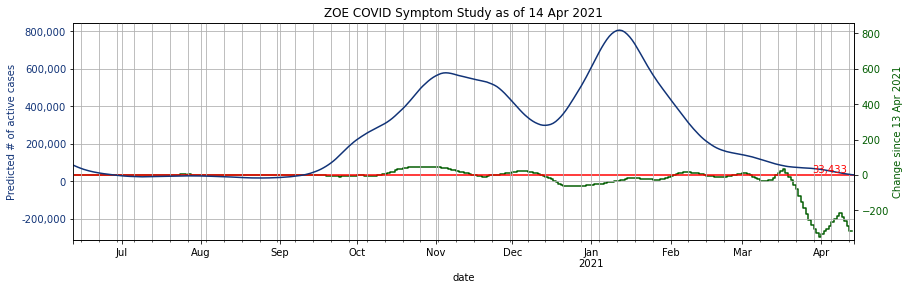

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

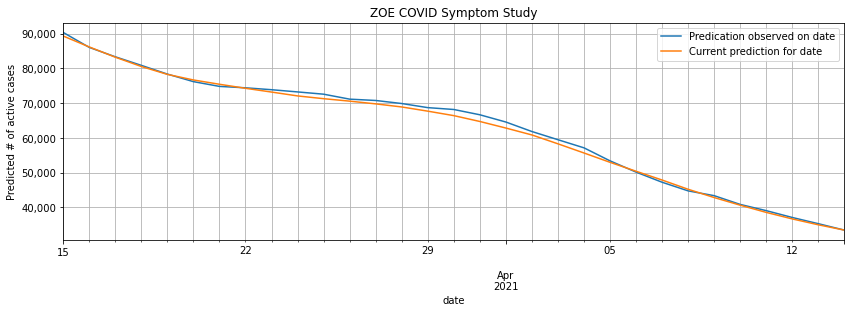

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-14_2021-04-14-16-53.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
301,Calderdale,E08000033,0.730478
294,Walsall,E08000030,0.589868
122,Castle Point,E07000069,0.429339
390,Dundee City,S12000042,0.424652
313,Aberdeen City,S12000033,0.328161
268,Oldham,E08000004,0.283122
247,Nuneaton and Bedworth,E07000219,0.279657
381,Rhondda Cynon Taf,W06000016,0.272547
326,Isle of Anglesey,W06000001,0.272213
372,Moray,S12000020,0.216377
